In [2]:
import sys
sys.path.append('../../../src')
from dimer_model_fit import *
from helpers import *
import random
import scipy.stats as st
%matplotlib notebook

if not os.path.exists('Figs'):
    os.mkdir('Figs')

### Import data

In [3]:
df_main = pd.read_csv('df_main.csv')
df_s1 = pd.read_csv('df_s1.csv')
df_s2 = pd.read_csv('df_s2.csv')

### Run analysis

In [4]:
# Association constants expressed in log10 form 
Ka_wt = 6.7447274949 # <- AUC measurement
Ka_mut = 6.7447274949 # <- initial guess
Km = 2.5 # <- initial guass
fix_wt = True
fix_mut = False
fit_D = False

free_analysis_main = EnergiesConfidenceIntervalPaired(df_main, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=False, 
                                                 fix_mut=fix_mut, fit_D=fit_D)
free_analysis_s1 = EnergiesConfidenceIntervalPaired(df_s1, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=False, 
                                               fix_mut=fix_mut, fit_D=fit_D)
free_analysis_s2 = EnergiesConfidenceIntervalPaired(df_s2, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=False, 
                                               fix_mut=fix_mut, fit_D=fit_D)

fixed_analysis_main = EnergiesConfidenceIntervalPaired(df_main, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=True, 
                                                 fix_mut=fix_mut, fit_D=fit_D)
fixed_analysis_s1 = EnergiesConfidenceIntervalPaired(df_s1, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=True, 
                                               fix_mut=fix_mut, fit_D=fit_D)
fixed_analysis_s2 = EnergiesConfidenceIntervalPaired(df_s2, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=True, 
                                               fix_mut=fix_mut, fit_D=fit_D)

### Plotting functions

In [5]:
class random_grouped_scatter:
    def __init__(self, linewidth=0.1, edgecolors='k', s=20):
        self.points = []
        self.linewidth = linewidth
        self.edgecolors = edgecolors
        self.s = s
    
    def add(self, x, y, color):
        for _x, _y in zip(x, y):
            self.points.append({'x':_x, 'y':_y, 'color':color})
    
    def plot(self, ax):
        random.shuffle(self.points)
        for p in self.points:
            ax.scatter(p['x'], p['y'], linewidth=self.linewidth, edgecolors=self.edgecolors, s=self.s, 
                       color=p['color'])
    
    
def rundown_plot(analysis, analysis2):
    
    # Initiate figure
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(2, 2,  width_ratios=(9, 2), height_ratios=(2, 9),
                          left=0.2, right=0.8, bottom=0.2, top=0.8,
                          wspace=0.1, hspace=0.1)
    ax = fig.add_subplot(gs[1, 0])
    ax_dimx = fig.add_subplot(gs[0, 0])
    ax_dimy = fig.add_subplot(gs[1, 1])
        
    # Scatter
    b = np.array([r == 'Pol' for r in analysis.unipol])    
    r = random_grouped_scatter()
    r.add(analysis.cyts[(analysis.l109r == 0) * ~b], analysis.mems[(analysis.l109r == 0) * ~b], lighten('tab:blue'))
    r.add(analysis.cyts[(analysis.l109r == 0) * b], analysis.mems[(analysis.l109r == 0) * b], 'tab:blue')
    r.add(analysis.cyts[(analysis.l109r == 1) * ~b], analysis.mems[(analysis.l109r == 1) * ~b], lighten('tab:orange'))
    r.add(analysis.cyts[(analysis.l109r == 1) * b], analysis.mems[(analysis.l109r == 1) * b], color='tab:orange')
    r.plot(ax)
    
    # Plot model 1
    ax.plot(analysis.res_x[0], analysis.res_y[0], c='k', linewidth=1)
    ax.plot(analysis.res_x[1], analysis.res_y[1], c='k', linewidth=1)
    
    # Plot model 2
    ax.plot(analysis2.res_x[0], analysis2.res_y[0], c='tab:gray', linewidth=1, linestyle='--')
    ax.plot(analysis2.res_x[1], analysis2.res_y[1], c='tab:gray', linewidth=1, linestyle='--')
    
    # Add lines and ticks
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for i in np.arange(-10, 10, 0.5):
        ax.plot([-10, 10], [i - 10, i + 10], c='0.9', zorder=-100, linewidth=1)
    ax.set_xticks(np.arange(-10, 0))
    ax.set_yticks(np.arange(-10, 0))
    minor_ticks(ax, [-10, 0], [-10, 0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter(fake_log)
    ax.yaxis.set_major_formatter(fake_log) 
    ax.set_xlabel('Cytoplasmic concentration (M)', fontsize=8)
    ax.set_ylabel('Membrane concentration (M)', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    
    # Set axis limits
    ax.set_ylim(min(analysis.mems) - 0.1, max(analysis.mems) + 0.2)
    ax.set_xlim(min(analysis.cyts) - 0.1, max(analysis.cyts) + 0.15)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Scatter - legend
    ax.scatter([], [], c='tab:blue', edgecolors='k', s=20, label='PAR-2 (WT)', linewidth=0.1)
    ax.scatter([], [], c='tab:orange', edgecolors='k', s=20, label='PAR-2 (L109R)', linewidth=0.1)
    ax.legend(fontsize=6, frameon=False, loc='upper left')
    
    # Cytoplasmic dimer fraction 1
    ax_dimx.plot(analysis.res_x[0], analysis.cyt_dim[0], c='tab:blue')
    ax_dimx.plot(analysis.res_x[1], analysis.cyt_dim[1], c='tab:orange')
    ax_dimx.set_ylim(-5, 105)
    ax_dimx.set_xlim(*xlim)
    ax_dimx.set_xticks([])
    ax_dimx.set_ylabel('% Dimer\n(cyt)', fontsize=8)
    ax_dimx.tick_params(axis='both', labelsize=8)
    
    # Cytoplasmic dimer fraction 2
    ax_dimx.plot(analysis2.res_x[0], analysis2.cyt_dim[0], c='tab:blue', linestyle='--')
    ax_dimx.plot(analysis2.res_x[1], analysis2.cyt_dim[1], c='tab:orange', linestyle='--')
    
    # Membrane dimer fraction 1
    ax_dimy.plot(analysis.mem_dim[0], analysis.res_y[0], c='tab:blue')
    ax_dimy.plot(analysis.mem_dim[1], analysis.res_y[1], c='tab:orange')
    ax_dimy.set_xlim(-5, 105)
    ax_dimy.set_ylim(*ylim)
    ax_dimy.set_yticks([])
    ax_dimy.set_xlabel('% Dimer\n(mem)', fontsize=8)
    ax_dimy.tick_params(axis='both', labelsize=8)
    
    # Membrane dimer fraction 2
    ax_dimy.plot(analysis2.mem_dim[0], analysis2.res_y[0], c='tab:blue', linestyle='--')
    ax_dimy.plot(analysis2.mem_dim[1], analysis2.res_y[1], c='tab:orange', linestyle='--')
    
#     # Text box
#     s1 = r'$w_d$' + f' (wt) = {analysis.wd_full[0]:.2f} (AUC)'
#     s2 = r'$w_d$' + f' (L109R) = {analysis.wd_full[1]:.2f} (fit)'
#     s3 = r'$w_m$' + f' = {analysis.wm_full:.2f} (fit)'
#     s = s1 + '\n' + s2 + '\n' + s3
#     ax.text(x=0.4, y=0.05, s=s, transform =ax.transAxes, horizontalalignment='left', verticalalignment='bottom',
#            fontsize=6, bbox=dict(facecolor='w', edgecolor='k', linewidth=0.5))
    
    return fig

<IPython.core.display.Javascript object>


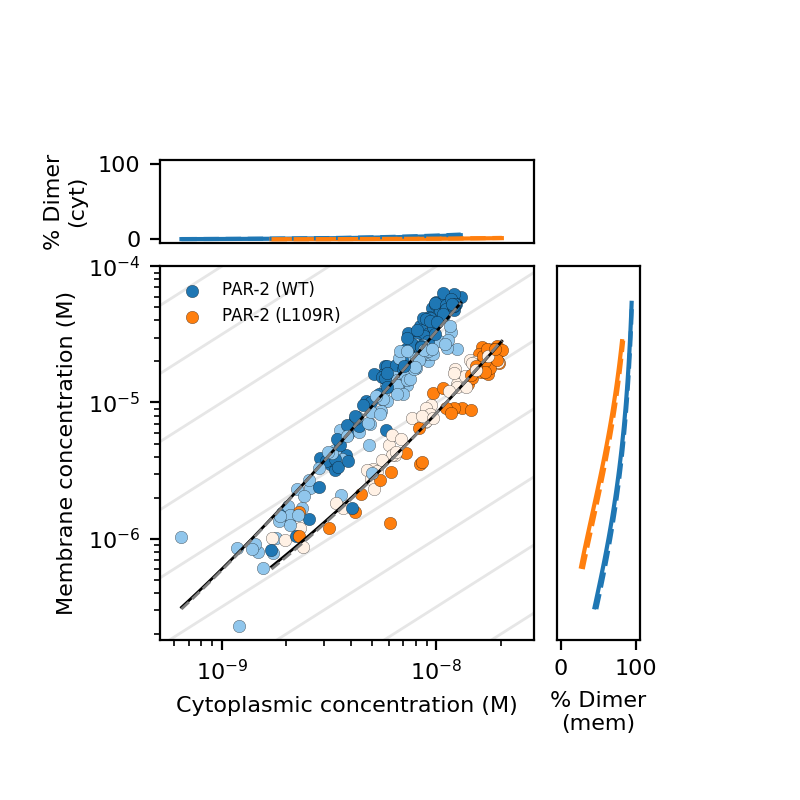

<IPython.core.display.Javascript object>


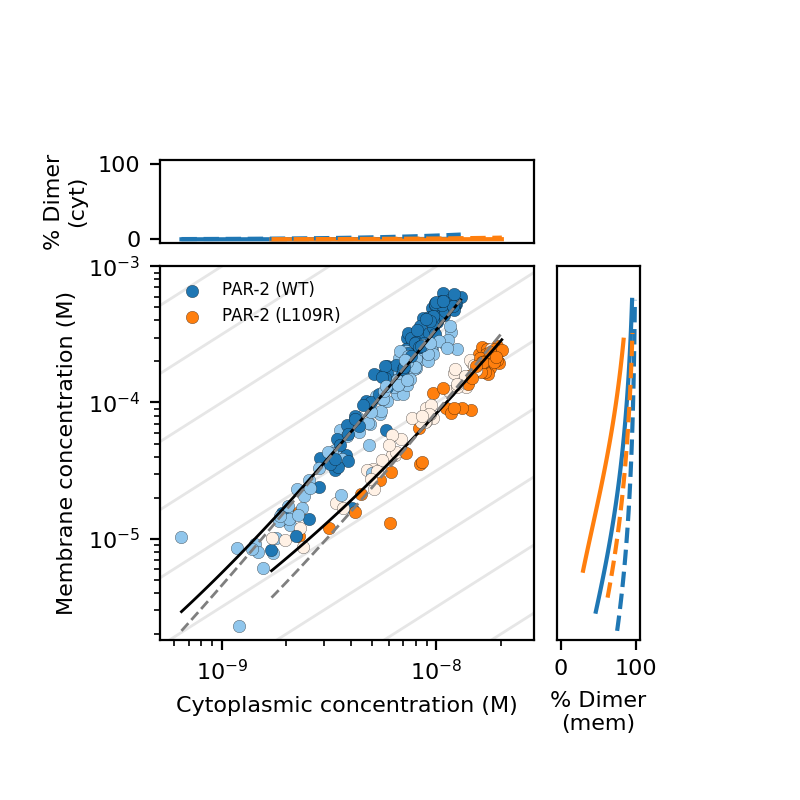

<IPython.core.display.Javascript object>


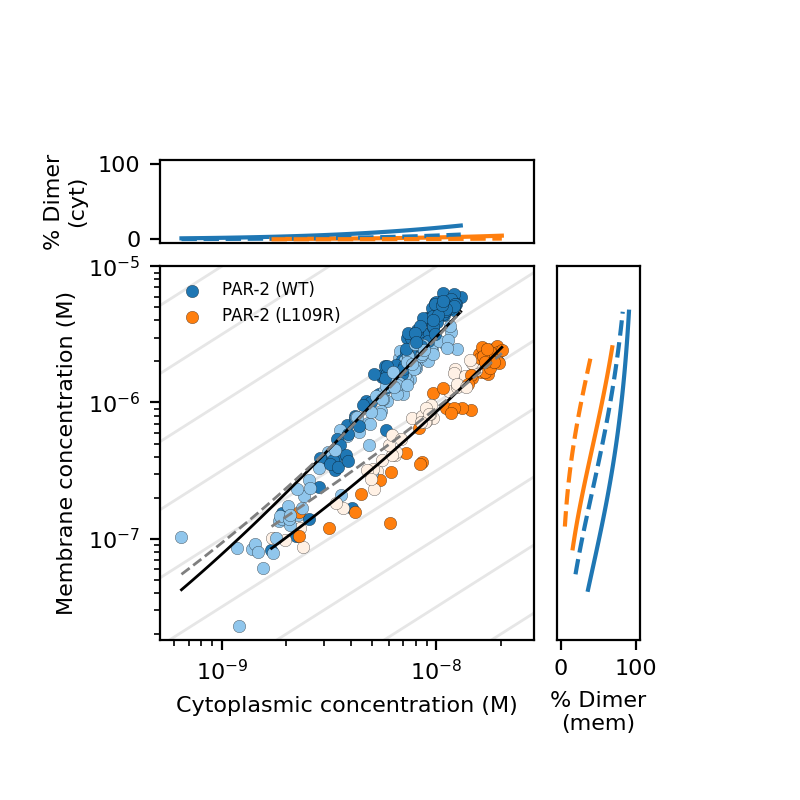

In [6]:
fig = rundown_plot(free_analysis_main, fixed_analysis_main)
fig = rundown_plot(free_analysis_s1, fixed_analysis_s1)
fig = rundown_plot(free_analysis_s2, fixed_analysis_s2)
# fig = rundown_plot(analysis_s3)
# fig = rundown_plot(analysis_s4)